
# About the Monocular Depth Estimation

>NYU Depth V2 provided an excellent dataset for depth estimation from monocular image. The training is done on RGB-D datasets. Using a Resnet50 as the encoder, the decoder is added, with interlinkages following concept of UNet. This derives probable results with less training epochs required.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

import pickle 
import glob
import cv2

import random
import os, sys
import re
from PIL import Image


from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.metrics import *
from tensorflow.keras.activations import *

# tf.enable_eager_execution()

from scipy.io import loadmat
import tables
import h5py

C:\Users\aivs\Anaconda3\envs\tensorflow\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\aivs\Anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\aivs\Anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\aivs\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\aivs\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type

In [3]:
from skimage import exposure
from skimage.io import imsave, imshow
from skimage.transform import resize

import keras

Using TensorFlow backend.


# Load NYU Depth v2 dataset

In [4]:
# !wget -qq http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat

In [5]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
# x = loadmat('nyu_depth_v2_labeled.mat') #Only for matlab before 7.3 files

In [7]:
nyu_filepath = 'nyu_depth_v2_labeled.mat'

In [8]:
nyu_file = h5py.File(nyu_filepath,'r')

## Exploration of MAT file for NYU Depth V2

In [9]:
for name, value in nyu_file.items():
  print(name, value)

#refs# <HDF5 group "/#refs#" (8484 members)>
#subsystem# <HDF5 group "/#subsystem#" (1 members)>
accelData <HDF5 dataset "accelData": shape (4, 1449), type "<f4">
depths <HDF5 dataset "depths": shape (1449, 640, 480), type "<f4">
images <HDF5 dataset "images": shape (1449, 3, 640, 480), type "|u1">
instances <HDF5 dataset "instances": shape (1449, 640, 480), type "|u1">
labels <HDF5 dataset "labels": shape (1449, 640, 480), type "<u2">
names <HDF5 dataset "names": shape (1, 894), type "|O">
namesToIds <HDF5 dataset "namesToIds": shape (1, 6), type "<u4">
rawDepthFilenames <HDF5 dataset "rawDepthFilenames": shape (1, 1449), type "|O">
rawDepths <HDF5 dataset "rawDepths": shape (1449, 640, 480), type "<f4">
rawRgbFilenames <HDF5 dataset "rawRgbFilenames": shape (1, 1449), type "|O">
sceneTypes <HDF5 dataset "sceneTypes": shape (1, 1449), type "|O">
scenes <HDF5 dataset "scenes": shape (1, 1449), type "|O">


In [10]:
for key in nyu_file.keys():
   print(key)

#refs#
#subsystem#
accelData
depths
images
instances
labels
names
namesToIds
rawDepthFilenames
rawDepths
rawRgbFilenames
sceneTypes
scenes


In [11]:
rawDepthFilenames = [u''.join(chr(c) for c in nyu_file[obj_ref]) for obj_ref in nyu_file['rawDepthFilenames'][0]]
names = [u''.join(chr(c) for c in nyu_file[obj_ref]) for obj_ref in nyu_file['names'][0]]
scenes = [u''.join(chr(c) for c in nyu_file[obj_ref]) for obj_ref in nyu_file['sceneTypes'][0]]
rawRgbFilenames = [u''.join(chr(c) for c in nyu_file[obj_ref]) for obj_ref in nyu_file['rawRgbFilenames'][0]]

In [12]:
labels = nyu_file['labels']
images = nyu_file['images']
depths = nyu_file['depths']
rawDepths = nyu_file['rawDepths']

In [13]:
rawDepthFilenames[0]

'kitchen_0004/d-1294851097.542259-2322437371.pgm'

In [14]:
len(images)

1449

### Images

In [15]:
def plot_color(ax, color, title="Color"):
    """Displays a color image from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(color)

In [16]:
def rotate_image(image):
    return image.rotate(-90, expand=True)

In [17]:
image_set=[]

In [18]:
for i, image in enumerate(images[:10]):
  image = np.moveaxis(image, 0, -1)
  # image = np.rot90(image,-1)
  if 'image_set' in globals():
    image_set.append(image)
  else:
    image_set=[]
    image_set.append(image)
    
print(np.array(image_set).shape)

(10, 640, 480, 3)


In [19]:
image_set = np.array(image_set)

In [20]:
image_set.shape

(10, 640, 480, 3)

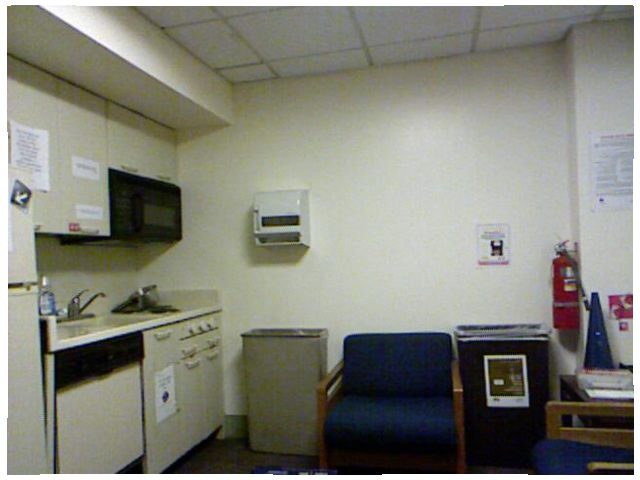

In [21]:
color_map = image_set[0]
color_image = Image.fromarray(color_map, mode='RGB')
color_image = rotate_image(color_image)
color_image

In [22]:
# The data exploration shows that the array extracted out from mat files already contain the image data.
# The numpy array has a range of (0,255) for colors with 3 channels.
# This suggests that further conversion to images is not required.
# To manage the reloading of data due to OOM in colab, we can save the array as a npy (numerical python)
# dataset first, which we can refer to later.

In [23]:
image_set=[]
for i, image in enumerate(images):
  image = np.moveaxis(image, 0, -1)
  image = np.rot90(image,-1)
  if 'image_set' in globals():
    image_set.append(image)
  else:
    image_set=[]
    image_set.append(image)
    
color_img_array = np.array(image_set)

In [24]:
# np.save('color_img.npy', color_img_array)

In [25]:
# color_img_array.shape

In [26]:
# print(np.nanmax(color_img_array))

In [27]:
# print(np.nanmin(color_img_array))

### Depths

In [28]:
depths.shape

(1449, 640, 480)

In [29]:
depth_set=[]

In [30]:
for i, depth in enumerate(depths[:20]):
  # depth = np.rot90(depth,-1)
  if 'depth_set' in globals():
    depth_set.append(depth)
  else:
    depth_set=[]
    depth_set.append(depth)
    
print(np.array(depth_set).shape)

(20, 640, 480)


In [31]:
depth_set = np.array(depth_set)

In [32]:
depth_map = depth_set[0]
depth_image = Image.fromarray(depth_map, mode='F')
depth_image = rotate_image(depth_image)
# depth_image #Printing image as png presents as an error, due to cannot write mode F

In [33]:
print(min(depth_map[0]))
print(max(depth_map[0]))

2.1979067
2.7520132


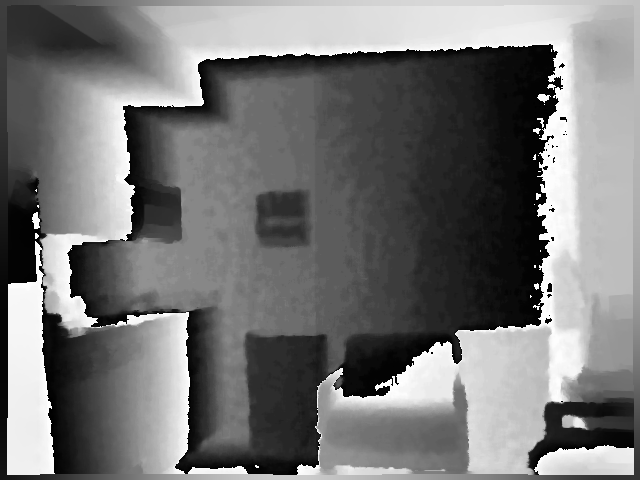

In [34]:
array = (depth_map*256).astype(np.uint8)
img = Image.fromarray(array)
img = rotate_image(img)
img

In [35]:
depth_set=[]

In [36]:
for i, depth in enumerate(depths):
  depth = np.rot90(depth,-1)
  if 'depth_set' in globals():
    depth_set.append(depth)
  else:
    depth_set=[]
    depth_set.append(depth)
    
# print(np.array(depth_set).shape)

In [37]:
depth_img_array = np.array(depth_set)

In [38]:
# print(np.nanmax(depth_img_array))

In [39]:
# print(np.nanmin(depth_img_array))

In [40]:
# np.save('/content/drive/My Drive/ACV_Aug_2019/nyu_depth/depth_img.npy', depth_img_array)

In [41]:
# depth_img_array = np.array(depth_set)

In [42]:
# np.save('depth_img.npy', depth_img_array)

### Raw Depths

In [43]:
rawDepths.shape

(1449, 640, 480)

In [44]:
rawdepth_set=[]

In [45]:
for i, rawdepth in enumerate(rawDepths[:20]):
#   rawdepth = np.rot90(rawdepth,-1)
  if 'rawdepth_set' in globals():
    rawdepth_set.append(rawdepth)
  else:
    rawdepth_set=[]
    rawdepth_set.append(rawdepth)
    
print(np.array(rawdepth_set).shape)

(20, 640, 480)


In [46]:
rawdepth_set = np.array(rawdepth_set)

In [47]:
rawdepth_map = rawdepth_set[0]
rawdepth_image = Image.fromarray(rawdepth_map, mode='F')
rawdepth_image = rotate_image(rawdepth_image)
# rawdepth_image #Printing image as png presents as an error, due to cannot write mode F

In [48]:
print(np.nanmin(rawdepth_map))
print(np.nanmax(rawdepth_map))

0.0
3.6404145


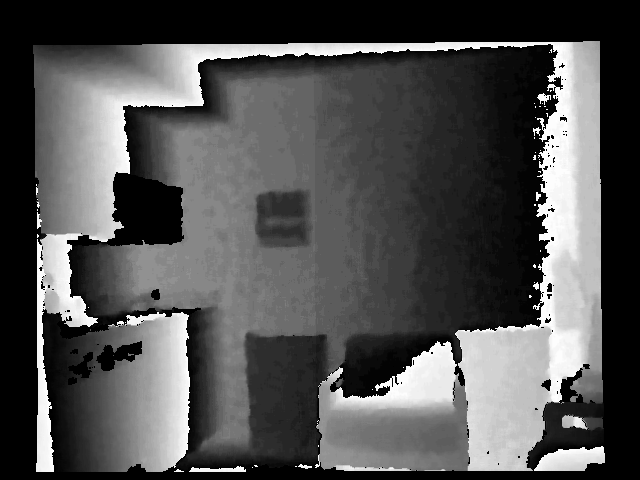

In [49]:
array = (rawdepth_map*256).astype(np.uint8)
img = Image.fromarray(array)
img = rotate_image(img)
img

In [50]:
rawdepth_set=[]

In [51]:
for i, rawdepth in enumerate(rawDepths):
  rawdepth = np.rot90(rawdepth,-1)
  if 'rawdepth_set' in globals():
    rawdepth_set.append(rawdepth)
  else:
    rawdepth_set=[]
    rawdepth_set.append(rawdepth)
    
print(np.array(rawdepth_set).shape)

(1449, 480, 640)


In [52]:
rawdepth_img_array = np.array(rawdepth_set)

In [53]:
# print(np.nanmax(rawdepth_img_array))

In [54]:
# print(np.nanmin(rawdepth_img_array))

In [55]:
# np.save('rawdepth_img.npy', rawdepth_img_array)

### Visualing using color map for depth images

> Google recently introduced an improved rainbow color map called Turbo for visualisation. This is great for visualising depths.

[Refer to the Turbo article here.](https://ai.googleblog.com/2019/08/turbo-improved-rainbow-colormap-for.html?m=1)



In [56]:
# !wget -qq https://raw.githubusercontent.com/vincentsohjh/course_assignments/master/turbo_colormap_mpl_custom.py

In [57]:
import turbo_colormap_mpl_custom

In [58]:
def plot_depth(ax, depth, title="Depth"):
    """Displays a depth map from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(depth, cmap='turbo_r')

In [59]:
def plot_color(ax, color, title="Color"):
    """Displays a color image from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(color)

In [60]:
image_set = color_img_array
depth_set = depth_img_array
rawdepth_set = rawdepth_img_array

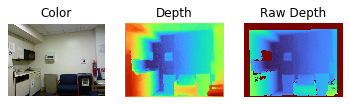

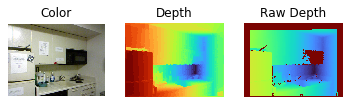

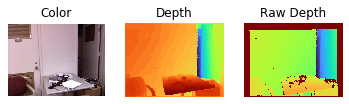

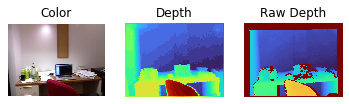

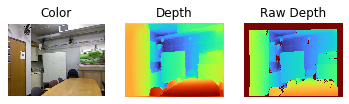

In [61]:
for i, image in enumerate(image_set[0:5]):
    color_map = image_set[i]
    color_image = Image.fromarray(color_map, mode='RGB')  

    depth_map = depth_set[i]
    depth_image = Image.fromarray(np.array((depth_map*255)/10,dtype=np.uint8)) 

    rawdepth_map = rawdepth_set[i]
    rawdepth_image = Image.fromarray(rawdepth_map, mode='F')

    # fig = plt.figure("Labeled Dataset Sample", figsize=(12, 5))

    fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
    plot_color(ax1,color_image)
    plot_depth(ax2, depth_image)
    plot_depth(ax3, rawdepth_image,"Raw Depth")

    fig = plt.figure("Labeled Dataset Sample", figsize=(12, 5))
    fig.clear()
    plt.close(fig)

## Exploration of Train Test Split provided

In [62]:
# !wget -qq http://horatio.cs.nyu.edu/mit/silberman/indoor_seg_sup/splits.mat

In [63]:
train_test = loadmat('splits.mat')

In [64]:
for key in train_test.keys():
  print(key)

__header__
__version__
__globals__
trainNdxs
testNdxs


In [65]:
# imshow(depth_set[0])

## Data Extraction

### Train and Test Images Split

In [66]:
test_images = np.array([int(x) for x in train_test["testNdxs"]])
train_images = np.array([int(x) for x in train_test["trainNdxs"]])
print("%d training images" % len(train_images))
print("%d test images" % len(test_images))

795 training images
654 test images


In [67]:
# test_images=set(test_images[0:20])
# train_images=set(train_images[0:20])

In [68]:
# train_test["testNdxs"]

In [69]:
# The list of train_images and test_images refer to the image number in the array.
# However, in an array list, the indexing starts from zero. Thus an adjustment is required.

In [70]:
test_images = test_images -1
train_images = train_images -1

In [71]:
train_images = train_images[:(len(train_images)//2)]
test_images = test_images[:(len(test_images)//2)]

### Custom save functions

In [72]:
# !pip install pypng
# import png

In [73]:
# def process_ground_truth(ground_truth):
#     colors = dict()
#     colors["structure"] = _solarized.colors[5]
#     colors["prop"] = _solarized.colors[8]
#     colors["furniture"] = _solarized.colors[9]
#     colors["floor"] = _solarized.colors[1]
#     shape = list(ground_truth.shape) + [3]
#     img = np.ndarray(shape=shape, dtype=np.uint8)
#     for i in range(shape[0]):
#         for j in range(shape[1]):
#             l = ground_truth[i, j]
#             if (l == 0):
#                 img[i, j] = (0, 0, 0)  # background
#             else:
#                 name = classes[names[l - 1]]
#                 assert name in colors, name
#                 img[i, j] = colors[name]
#     return img


# def visualize_depth_image(data):

#     data[data == 0.0] = np.nan

#     maxdepth = np.nanmax(data)
#     mindepth = np.nanmin(data)
#     data = data.copy()
#     data -= mindepth
#     data /= (maxdepth - mindepth)

#     gray = np.zeros(list(data.shape) + [3], dtype=data.dtype)
#     data = (1.0 - data)
#     gray[..., :3] = np.dstack((data, data, data))

#     # use a greenish color to visualize missing depth
#     gray[np.isnan(data), :] = (97, 160, 123)
#     gray[np.isnan(data), :] /= 255

#     gray = exposure.equalize_hist(gray)

#     # set alpha channel
#     gray = np.dstack((gray, np.ones(data.shape[:2])))
#     gray[np.isnan(data), -1] = 0.5

#     return gray * 255

In [74]:
# def convert_image(i, scene, img_depth, image, label):
#   idx = int(i) + 1
#   if idx in train_images:
#       train_test = "training"
#   else:
#       assert idx in test_images, "index %d neither found in training set nor in test set" % idx
#       train_test = "testing"

#   folder = "%s/%s/%s" % (out_folder, train_test, scene)
#   if not os.path.exists(folder):
#       os.makedirs(folder)

#   img_depth = img_depth * 1000.0

# #   png.from_array(img_depth, 'L;16').save("%s/%05d_depth.png" % (folder, i))

#   depth_visualization = visualize_depth_image(img_depth)

#   # workaround for a bug in the png module
#   depth_visualization = depth_visualization.copy()  # makes in contiguous
#   shape = depth_visualization.shape
#   depth_visualization.shape = (shape[0], np.prod(shape[1:]))

#   depth_image = png.from_array(depth_visualization, "RGBA;8")
#   depth_image.save("%s/%05d_depth_visualization.png" % (folder, i))

#   imsave("%s/%05d_colors.png" % (folder, i), image)

#   # ground_truth = process_ground_truth(label)
#   # imsave("%s/%05d_ground_truth.png" % (folder, i), ground_truth)

In [75]:
# out_folder="./"

In [76]:
# for i, image in enumerate(images[:20]):
#   print("image", i + 1, "/", len(images))
#   convert_image(i, scenes[i], depths[i, :, :].T, image.T, labels[i, :, :].T)

### PNG Extraction

In [77]:
# def extract_image(i, scene, depth_img, color_img, label):
#   idx = int(i) + 1
#   if idx in train_images:
#       train_test = "training"
#   else:
#       assert idx in test_images, "index %d neither found in training set nor in test set" % idx
#       train_test = "testing"

#   folder = "%s/%s/%s" % (out_folder, train_test, scene)
#   if not os.path.exists(folder):
#       os.makedirs(folder)

#   color_img = np.moveaxis(color_img, 0, -1)
#   color_img = np.rot90(color_img,-1)
#   color_img = Image.fromarray(color_img, mode='RGB')
#   color_img = np.asanyarray(color_img)
#   # imshow(color_img)
#   imsave("%s/%05d_colors.png" % (folder, i), color_img)

  
#   depth_img = np.rot90(depth_img,-1)
#   depth_img = Image.fromarray(depth_img, mode='F')
#   depth_img = np.asanyarray(depth_img)
#   # imshow(depth_img, cmap='turbo')
  
#   imsave("%s/%05d_depth.png" % (folder, i), depth_img)

In [78]:
# for i, image in enumerate(images[:50]):
#   print("image", i + 1, "/", len(images))
#   extract_image(i, scenes[i], depths[i, :, :], image, labels[i, :, :])

In [79]:
# !rm -r training

# Data Pipeline

## Custom Generator

>Custom Data Generator for numpy array

https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [80]:
from tensorflow.python.keras.utils.data_utils import Sequence

In [81]:
# color_img_array = np.load('color_img.npy')
# depth_img_array = np.load('depth_img.npy')

In [82]:
# color_img_array = np.load('/content/drive/My Drive/ACV_Aug_2019/nyu_depth/color_img.npy')
# depth_img_array = np.load('/content/drive/My Drive/ACV_Aug_2019/nyu_depth/depth_img.npy')

In [83]:
from skimage.transform import resize
def nyu_resize(img, resolution=480, padding=6):
    return resize(img, (resolution, int(resolution*4/3)), preserve_range=True, mode='reflect', anti_aliasing=True )

In [84]:
def img_augment(img, depth):
    if random.uniform(0, 1) <= 0.5:#flip_ud_ratio
        img = np.flipud(img)
        depth = np.flipud(depth)
    
    if random.uniform(0, 1) < 0.5:#flip_lr_ratio
        img = np.fliplr(img)
        depth = np.fliplr(depth)
    
    return img, depth

In [85]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, img_set, rdepth_set, batch_size=16, shuffle=True, val_set=False):
        'Initialization'
        
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.img_set = img_set
        self.rdepth_set = rdepth_set
        self.img_dim = img_set[0].shape
        self.rdepth_dim = (240,320)
        self.maxDepth = 1000.0
        self.shuffle = shuffle
        self.N = len(self.img_set)
        self.val_set = val_set
        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
#         if self.val_set == True:
#           self.indexes = self.indexes[:8]


    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        # print(indexes)
        # index = min((idx * self.batch_size) + i, self.N-1)
        # indexes = min((index * self.batch_size) + i, self.N-1)

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # print(list_IDs_temp)

        # Generate data
        batch_x, batch_y = self.__data_generation(list_IDs_temp)
        # print(batch_x.shape,batch_y.shape)

        return batch_x, batch_y    

    def __data_generation(self, list_IDs_temp):
#     def __getitem__(self, idx):
        'Generates data containing batch_size samples from the mat np array set' # X : (n_samples)
    
        # Initialization
        batch_x, batch_y = np.zeros((self.batch_size, *self.img_dim)), np.zeros((self.batch_size, *self.rdepth_dim, 1))
        # batch_x, batch_y = np.zeros((self.batch_size, 480, 640, 3)), np.zeros((self.batch_size, 240, 320, 3))
        # print(batch_x.shape,batch_y.shape)


        for i, ID in enumerate(list_IDs_temp):
            # print(i,ID)

            # Store base image

            # An option is to convert all the arrays into images. This will facilitate the image augmentation,
            # for both the source and the depth images (i.e. similar to masked images concept).


            x_temp = np.asarray(Image.fromarray(self.img_set[ID],mode='RGB'))
            y_temp = np.asarray(Image.fromarray(np.array((self.rdepth_set[ID]*255)/10,dtype=np.uint8)))
            
            x_temp, y_temp = img_augment(x_temp, y_temp)
            
            
            
            x_temp = np.clip(np.asarray(x_temp).reshape(480,640,3)/255,0,1)
            batch_x[i] = nyu_resize(x_temp,480)
            
            

            #          

            # Store depth image          
            

            y_temp = resize((np.asarray(y_temp)/255),(240,320,1))

            # y_temp = np.asarray(Image.fromarray(self.rdepth_set[ID],mode='F'), dtype=np.float32).reshape(480,640,1)

            #           y_temp = np.clip(y_temp/self.maxDepth,0,1)
            batch_y[i] = nyu_resize(y_temp,240)



            #         print(ID)
            #         print(batch_x.shape,batch_y.shape)
          

        return batch_x, batch_y

# TF Data Pipeline

## Model

### BiLinear Up Sampling

In [86]:
class BilinearUpSampling2D(Layer):
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(BilinearUpSampling2D, self).__init__(**kwargs)
        self.data_format = K.normalize_data_format(data_format)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
            return (input_shape[0],
                    input_shape[1],
                    height,
                    width)
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
            return (input_shape[0],
                    height,
                    width,
                    input_shape[3])

    def call(self, inputs):
        input_shape = K.shape(inputs)
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
        
        return tf.image.resize(inputs, [height, width], method=tf.image.ResizeMethod.BILINEAR, align_corners=True)

    def get_config(self):
        config = {'size': self.size, 'data_format': self.data_format}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### Loss function

In [87]:
def depth_loss_function(y_true, y_pred, theta=0.1, maxDepthVal=1000.0/10.0):
    
    # Point-wise depth
    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)

    # Edges
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    # Structural similarity (SSIM) index
    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, maxDepthVal)) * 0.5, 0, 1)

    # Weights
    w1 = 1.0
    w2 = 1.0
    w3 = theta

    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

In [88]:
def scale_invariant_loss(y_true, y_pred):
  log_diff = tf.reduce_mean( tf.log(y_pred) - tf.log(y_true) )
  x = tf.square( (tf.log(y_true) - tf.log(y_pred)) + log_diff )
  x = 0.5*tf.reduce_mean(x)

  return x

def square_error_loss(y_true, y_pred):

  x = tf.reduce_mean( tf.square(y_pred - y_true) )

  return x

def berhu_loss(y_true, y_pred):
  e = tf.abs(y_true - y_pred)
  valid = tf.cast(tf.not_equal(y_true,0), tf.float32)
  c = 0.2*tf.reduce_max(e)
  l1 = tf.cast(tf.greater(c,e), tf.float32)
  l2 = tf.cast(tf.greater(e,c), tf.float32)
  x = (l1 * e) + (l2 * (tf.square(e) + tf.square(c))/(2*c) )
  return tf.reduce_mean(tf.multiply(x,valid))

def rel_error(y_true, y_pred):
  x = tf.reduce_mean( tf.divide( tf.abs(y_true-y_pred), y_true ) )
  return x

def rmse_custom(y_true, y_pred):
  x = tf.sqrt( tf.reduce_mean( tf.square(y_true-y_pred) ) )
  return x

### Create the main model

In [89]:
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras import applications
import keras.backend as K
from keras.utils import conv_utils

In [90]:
# base_model = applications.resnet50.ResNet50(weights='imagenet',input_shape=(480, 640, 3), include_top=False)

In [91]:
# base_model.summary()

In [92]:
# for i, layer in enumerate(base_model.layers):
#     print(i, ' ',layer.name)

In [93]:
def create_model(existing=''):
        
    if len(existing) == 0:
        print('Loading base model (ResNet50)..')

        base_model = applications.ResNet50(weights='imagenet',input_shape=(None, None, 3), include_top=False)
        
        print('Base model loaded.')

        # Starting point for decoder
        base_model_output_shape = base_model.layers[-1].output.shape
        # print(base_model_output_shape)
        
        # Concat points on encoder side
        conenc1 = base_model.get_layer(index=4).output
        conenc2 = base_model.get_layer(index=38).output
        conenc3 = base_model.get_layer(index=80).output
        conenc4 = base_model.get_layer(index=142).output
    

        # Layer not freeze
        for layer in base_model.layers: layer.trainable = True

        # Starting number of decoder filters
        decode_filters = int(int(base_model_output_shape[-1])/2)

        # Define upsampling / up-projection layer
        def upproject_block(tensor, filters, stage, block, concat_with, strides=1):

          upproject_name_base = 'ups' + str(stage) + str(block) + '_branch'
          bn_name_base = 'bn' + str(stage) + str(block) + '_branch'
          # filters1 = int(filters)
          # filters2 = int(filters/2)

          up_input = UpSampling2D(name=upproject_name_base + 'UpSample2D')(tensor)
          # print(up_input)
          up_input = Concatenate(name=upproject_name_base+'_concat')([up_input, concat_with])
          up_input = Conv2D(filters, (3, 3), strides=strides, padding='same', name=upproject_name_base + '2a')(up_input)
          up_input = BatchNormalization(name=bn_name_base + '_bn')(up_input)
          up_input = LeakyReLU(alpha=0.2)(up_input)
          up_input = Conv2D(filters, (3,3), strides=strides, padding='same', name=upproject_name_base + '2b')(up_input)
          # up_input = Dropout(0.3)(up_input)

          # shortcut = Conv2D(filters, (3, 3), strides=strides, padding='same', name=upproject_name_base + 'sc')(up_input)
          # up_input = add([up_input, shortcut])
          up_input = LeakyReLU(alpha=0.2)(up_input)

          return up_input

        # Define Transition Layer
        def transition_lyr(tensor, filters, kernel_size, stage, block, bnorm=True):
          translyr_name_base = 'translyr' + str(stage) + str(block) + '_branch'
          bn_name_base = 'bn' + str(stage) + str(block) + '_branch'

          trans_lyr = Conv2D(filters, kernel_size, padding='same', strides=1, name=translyr_name_base + '1')(tensor)
          if bnorm == True:
            trans_lyr = BatchNormalization(name=bn_name_base + '1')(trans_lyr)

          return trans_lyr

          
        # Decoder Layers

        # Transition Layer
        decode_lyr = transition_lyr(base_model.output, filters=decode_filters, kernel_size=1,stage=6, block='a')
        # print(decode_lyr.shape, decode_filters)

        # Upscaling / Up Projection
        decode_lyr = upproject_block(decode_lyr,int(decode_filters/2),stage=7,block='a',concat_with=conenc4) #30,40,1024
        # print(decode_lyr.shape,int(decode_filters/2))
        decode_lyr = upproject_block(decode_lyr,int(decode_filters/4),stage=7,block='b',concat_with=conenc3) #60,80,512
        # print(decode_lyr.shape)
        decode_lyr = upproject_block(decode_lyr,int(decode_filters/16),stage=7,block='c',concat_with=conenc2) #120,160,256
        # print(decode_lyr.shape)
        decode_lyr = upproject_block(decode_lyr,int(decode_filters/16),stage=7,block='d',concat_with=conenc1) #240,320,64
        # print(decode_lyr.shape)
        # decode_lyr = upproject_block(decode_lyr,int(decode_filters/16),stage=7,block='e',concat_with='input_1')

        # Extract depths (final layer)
        final_lyr = transition_lyr(decode_lyr, filters=1, kernel_size=3, stage=8, block='a', bnorm=False)
        # final_lyr = transition_lyr(decode_lyr, filters=3, kernel_size=3, stage=8, block='a', bnorm=False)
        final_lyr = LeakyReLU(alpha=0.2)(final_lyr)
        # print(final_lyr.shape)

        # Create the model
        model = Model(inputs=base_model.input, outputs=final_lyr)

    else:
        # Load model from file
        if not existing.endswith('.h5'):
            sys.exit('Please provide a correct model file when using [existing] argument.')
        custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': depth_loss_function, 'berhu_loss':berhu_loss, 
                          'rel_error':rel_error,'rmse_custom':rmse_custom,'square_error_loss':square_error_loss}
        model = load_model(existing, custom_objects=custom_objects)
        print('\nExisting model loaded.\n')

    print('Model created.')
    
    return model

### Setting model parameters

In [94]:
# model = create_model()
model = create_model('./weights_resunet.41-0.0657851.h5')

W0927 00:01:06.768062 22380 deprecation.py:506] From C:\Users\aivs\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0927 00:01:06.771055 22380 deprecation.py:506] From C:\Users\aivs\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0927 00:01:06.778036 22380 deprecation.py:506] From C:\Users\aivs\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.ini


Existing model loaded.

Model created.


In [96]:
# optimizer = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)

In [97]:
model.compile(optimizer='Adagrad', loss=berhu_loss, metrics=[rel_error,rmse_custom,square_error_loss])

In [98]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
______________________________________________________________________________________________

In [99]:
batch_size = 4

In [100]:
train_images.dtype

dtype('int32')

In [101]:
train_dataset = DataGenerator(train_images,color_img_array,depth_img_array, batch_size=batch_size)

In [102]:
steps_per_epoch=(len(train_dataset) // batch_size)
steps_per_epoch

24

In [103]:
from sklearn.utils import shuffle

In [104]:
test_dataset = DataGenerator(test_images,color_img_array,depth_img_array,val_set=True)

In [105]:
# val_steps_per_epoch=(len(test_dataset) // 2)
# val_steps_per_epoch

### Running the model

In [106]:
# !cp './saved_model/weights.24-0.00026.hdf5' 'drive/My Drive/ACV_Aug_2019/nyu_depth'
# !cp 'rawdepth_img.npy' 'drive/My Drive/ACV_Aug_2019/nyu_depth'

In [107]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

In [108]:
es = EarlyStopping(monitor='val_loss', patience=30)
checkpoint_path = './drive/My Drive/ACV_Aug_2019/nyu_depth/resunet_rs/weights_resunet.{epoch:02d}-{val_loss:.7f}.h5'
checkpoint_path2 = './weights_resunet.{epoch:02d}-{val_loss:.7f}.h5'
model_chkpt = ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True)
model_chkpt2 = ModelCheckpoint(checkpoint_path2, verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [109]:
model.fit_generator(train_dataset, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,validation_data=test_dataset,
                    shuffle=True, callbacks=[model_chkpt2,reduce_lr])

C:\Users\aivs\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\aivs\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 1/20
23/24 [===========================>..] - ETA: 0s - loss: 0.1621 - rel_error: 0.6435 - rmse_custom: 0.2069 - square_error_loss: 0.0472
Epoch 00001: val_loss improved from inf to 0.19715, saving model to ./weights_resunet.01-0.1971498.h5
24/24 [==============================] - 64s 3s/step - loss: 0.1631 - rel_error: 0.6344 - rmse_custom: 0.2078 - square_error_loss: 0.0474 - val_loss: 0.1971 - val_rel_error: 0.8093 - val_rmse_custom: 0.2482 - val_square_error_loss: 0.0622
Epoch 2/20
23/24 [===========================>..] - ETA: 0s - loss: 0.1082 - rel_error: 0.4350 - rmse_custom: 0.1458 - square_error_loss: 0.0224
Epoch 00002: val_loss improved from 0.19715 to 0.10982, saving model to ./weights_resunet.02-0.1098226.h5
24/24 [==============================] - 35s 1s/step - loss: 0.1081 - rel_error: 0.4350 - rmse_custom: 0.1459 - square_error_loss: 0.0224 - val_loss: 0.1098 - val_rel_error: 0.4536 - val_rmse_custom: 0.1570 - val_square_error_loss: 0.0251
Epoch 3/20
23/24 [======

Epoch 19/20
23/24 [===========================>..] - ETA: 0s - loss: 0.0694 - rel_error: 0.2886 - rmse_custom: 0.0955 - square_error_loss: 0.0098
Epoch 00019: val_loss did not improve from 0.07622
24/24 [==============================] - 34s 1s/step - loss: 0.0694 - rel_error: 0.2895 - rmse_custom: 0.0952 - square_error_loss: 0.0097 - val_loss: 0.0781 - val_rel_error: 0.3667 - val_rmse_custom: 0.1175 - val_square_error_loss: 0.0142
Epoch 20/20
23/24 [===========================>..] - ETA: 0s - loss: 0.0675 - rel_error: 0.2824 - rmse_custom: 0.0911 - square_error_loss: 0.0086
Epoch 00020: val_loss improved from 0.07622 to 0.07340, saving model to ./weights_resunet.20-0.0733956.h5
24/24 [==============================] - 34s 1s/step - loss: 0.0674 - rel_error: 0.2790 - rmse_custom: 0.0911 - square_error_loss: 0.0086 - val_loss: 0.0734 - val_rel_error: 0.3419 - val_rmse_custom: 0.1023 - val_square_error_loss: 0.0106


In [ ]:
# model.save('./drive/My Drive/ACV_Aug_2019/nyu_depth/weights_resunet_batch1.h5')
# model.load_weights('./drive/My Drive/ACV_Aug_2019/nyu_depth/weights_resunet_batch1.h5')
# es = EarlyStopping(monitor='val_loss', patience=50)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=25, min_lr=0.0001)

In [ ]:
# model.fit_generator(train_dataset, steps_per_epoch=steps_per_epoch, epochs=500, verbose=1,validation_data=test_dataset,
#                     shuffle=True, callbacks=[model_chkpt,model_chkpt2,reduce_lr])

In [ ]:
# model.save('./drive/My Drive/ACV_Aug_2019/nyu_depth/weights_resunet_batch2.h5')
# model.load_weights('./drive/My Drive/ACV_Aug_2019/nyu_depth/weights_resunet_batch2.h5')
# es = EarlyStopping(monitor='val_loss', patience=100)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=50, min_lr=0.0001)

In [ ]:
# model.fit_generator(train_dataset, steps_per_epoch=steps_per_epoch, epochs=3000, verbose=1,validation_data=test_dataset,
#                     shuffle=True, callbacks=[model_chkpt,model_chkpt2,reduce_lr])

## Prediction

In [ ]:
# custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': depth_loss_function}
# # model = load_model('drive/My Drive/ACV_Aug_2019/nyu_depth/weights_unet.192-0.0001876.h5', custom_objects=custom_objects)
# model = load_model('drive/My Drive/ACV_Aug_2019/nyu_depth/weights_unet.07-0.0001869.h5', custom_objects=custom_objects)
# # model = model.load_weights('drive/My Drive/ACV_Aug_2019/nyu_depth/nyu.h5')

In [ ]:
# custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D}
# model = create_model('drive/My Drive/ACV_Aug_2019/nyu_depth/weights_densenetbn.06-0.0024625.h5')

In [ ]:
color_img_array[0:1].shape

In [ ]:
j=0
input_batch=np.zeros((3,480,640,3))
for i in range(280,282):
  print(i)
  j+=1
  input_batch[j]= np.clip(np.asarray(Image.fromarray(color_img_array[i],mode='RGB')).reshape(480,640,3)/255,0,1)

In [130]:
images=color_img_array[30:38]

In [131]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [132]:
# session.run(model.predict(images))

In [133]:
# if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
# if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))

In [134]:
results = model.predict(images)

In [135]:
results[0].shape

(240, 320, 1)

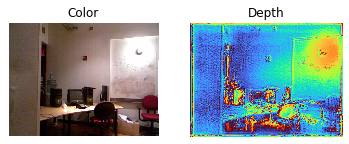

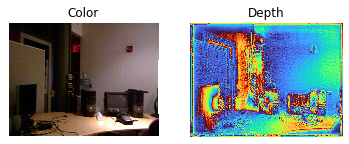

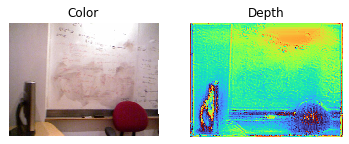

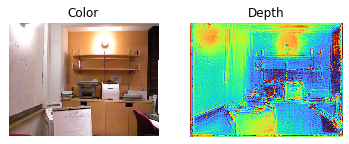

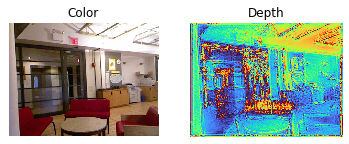

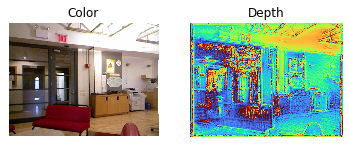

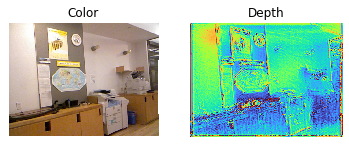

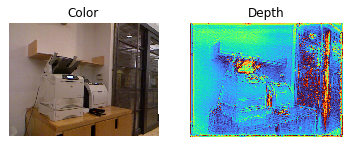

In [136]:
for i, rsimage in enumerate(results):
  color_map = images[i]
  color_image = Image.fromarray(color_map, mode='RGB')  

  depth_map = np.reshape(rsimage,(240,320))
  depth_image = Image.fromarray(np.array((depth_map*255)/10,dtype=np.uint8))

  fig, (ax1, ax2,) = plt.subplots(1, 2)
  plot_color(ax1,color_image)
  plot_depth(ax2, depth_image,"Depth")

  fig = plt.figure("Labeled Dataset Sample", figsize=(12, 5))
  fig.clear()
  plt.close(fig)

In [ ]:
depth_map